## Accessing FVCOM GOM Archive data

The SMAST thredds catalog has archived data arranged by year stored here: http://www.smast.umassd.edu:8080/thredds/catalog/models/fvcom/NECOFS/Archive/NECOFS_GOM/catalog.html

Data is available for **2016-2023**

Using these endpoints we can access data for a specific range of time.

In [2]:
# Libraries

# Import Libraries
import xarray as xr
import os
import matplotlib.pyplot as plt
import math

#importing modules used as auxiliary
from dateutil import parser
from datetime import datetime,timedelta

# Set directory of where to save a manageable piece (relative path)
os.chdir("../data")
os.getcwd()

'/Users/akemberling/Documents/Repositories/FVCOM_indicators/data'

##  Accessing One Month from a Single Year

Inspiration taken from this great resource here: 
https://github.com/iuryt/FVCOMpy/blob/main/examples/00-GettingStarted.ipynb

This will access a single month of FVCOM data from SMAST's THREDDs catalogue. Links to THREDDs endpoints are generated following the hierarchical folder structure. The dataset can then be accessed directly from the URL to be lazy-loaded into the notebook.


#### Refining OpenDap Links

Server-side data filters can be applied through modification of the URL links. Each THREDDS catalog entry has a link to its relevant data access form, that will generate the appropriate URL structures based on data needs.

ex. http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201601.nc.html

In [3]:
#Define year and month to be read - each one is 95GB
year = 2016
month = 5

# list problematic coordinates
drop_variables = ['siglay','siglev']


# Link structure
base_url = "http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/"
year_month_ext = f"{year}/gom4_{year}{month:02d}.nc"

# Data Filter Extentions - How to ask for less data



# Build URL(s)
url = f"{base_url}{year_month_ext}"


# lazy load of the data
ds = xr.open_dataset(url,drop_variables=drop_variables, decode_times=False)

# convert lon/c, lat/c to coordinates
ds = ds.assign_coords({var:ds[var] for var in ['lon','lat','lonc','latc']})
ds

<xarray.Dataset>
Dimensions:        (nele: 99137, node: 53087, three: 3, time: 744, maxnode: 11,
                    maxelem: 9, four: 4, siglay: 40, siglev: 41)
Coordinates:
    x              (node) float32 1.7e+06 1.705e+06 ... 5.841e+05 5.848e+05
    y              (node) float32 4.205e+05 4.149e+05 ... -1.279e+05 -1.28e+05
    lon            (node) float32 ...
    lat            (node) float32 ...
    lonc           (nele) float32 ...
    latc           (nele) float32 ...
  * time           (time) float32 5.751e+04 5.751e+04 ... 5.754e+04 5.754e+04
Dimensions without coordinates: nele, node, three, maxnode, maxelem, four,
                                siglay, siglev
Data variables: (12/47)
    nprocs         int32 ...
    partition      (nele) int32 ...
    xc             (nele) float32 ...
    yc             (nele) float32 ...
    h              (node) float32 ...
    nv             (three, nele) int32 ...
    ...             ...
    vwind_stress   (time, nele) float32 ...
    icing_0kts     (time, node) float32 ...
    icing_10kts    (time, node) float32 ...
    icing_wndx     (time, node) float32 ...
    icing_wndy     (time, node) float32 ...
    icing_satmp    (time, node) float32 ...
Attributes: (12/20)
    title:                           FVCOM GOM NECOFS HINDCAST UPDATE
    institution:                     School for Marine Science and Technology
    source:                          FVCOM_3.0
    history:                         Tue Mar 21 10:46:09 2017: ncrcat -d time...
    references:                      http://fvcom.smast.umassd.edu, http://co...
    Conventions:                     CF-1.0
    ...                              ...
    Icing_Model_Forcing:             FVCOM variable surface icing forcing:\nF...
    Special_Physical_processes:      long shore flow adjustment for thermal w...
    nco_openmp_thread_number:        1
    DODS.strlen:                     26
    DODS.dimName:                    DateStrLen
    DODS_EXTRA.Unlimited_Dimension:  time

### Fixing Dates

In [4]:
# Fix time to see what the thirty years is:

# the first day
dt0 = parser.parse(ds.time.attrs['units'].replace('days since ',''))

# parse dates summing days to the origin
ds = ds.assign(time = [dt0 + timedelta(seconds = day * 86400) for day in ds.time.values])


### Exploring Content

Variables of interest are u, ua, v, & va

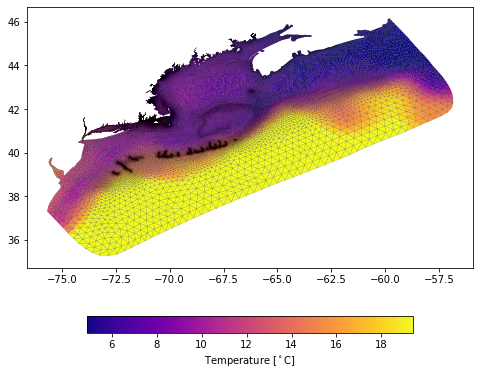

In [5]:
# select the surface layer and the first time output
isel = dict(siglay=0,time=0)

# Set fig, ax
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Do something about the triangles...
triangles = ds.nv.values.transpose() - 1


# Formatting function for the units
fmt = lambda txt: txt.replace('degrees_','$^\circ$').replace('1e-3','10$^{-3}$')

# Key argument function that defines vlim from data quantiles
kw = lambda da,q: {"edgecolor":"k", "linewidth": 0.1, "vmin":da.quantile(q[0]).values,"vmax":da.quantile(q[1]).values}


# Build a plot
da = ds.temp.isel(**isel)

# Trianglur Grid with Fill Color
C = ax.tripcolor(da.lon, da.lat, triangles, da, **kw(da,[0.01,0.99]),cmap='plasma')
fig.colorbar(C,ax=ax,label=f"{da.long_name.capitalize()} [{fmt(da.units)}]",fraction=0.05,orientation="horizontal")



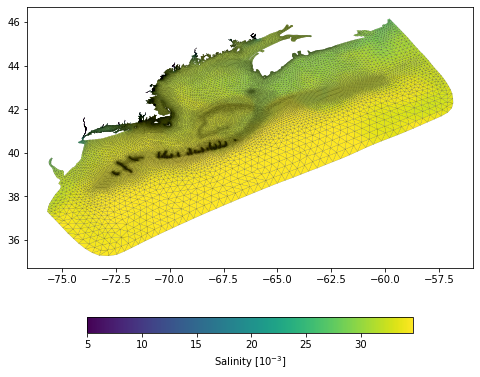

In [17]:
# Do Salinity

# select the surface layer and the first time output
isel = dict(siglay=0,time=0)

# Set fig, ax
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Build a plot
da = ds.salinity.isel(**isel)

# Trianglur Grid with Fill Color
C = ax.tripcolor(da.lon, da.lat, triangles, da, **kw(da,[0.01,0.99]),cmap='viridis')
fig.colorbar(C,ax=ax,label=f"{da.long_name.capitalize()} [{fmt(da.units)}]",fraction=0.05,orientation="horizontal")

---

### Attempt at Filtering Extents Before Re-Grid

FVCOM data is dense, we can reduce the memory and compute needed by limiting the area. The lon and lat coordinates for the nodes are not indexed coordinates, so we can try and index them first to allow selection. 

Relevant github issue:
https://github.com/pydata/xarray/issues/2028#issuecomment-1265252754

In [20]:
# We can make lat and lon indexed coordinates
ds.set_xindex("lon").set_xindex("lat")

<xarray.Dataset>
Dimensions:        (nele: 99137, node: 53087, three: 3, time: 744, maxnode: 11,
                    maxelem: 9, four: 4, siglay: 40, siglev: 41)
Coordinates:
    x              (node) float32 1.7e+06 1.705e+06 ... 5.841e+05 5.848e+05
    y              (node) float32 4.205e+05 4.149e+05 ... -1.279e+05 -1.28e+05
  * lon            (node) float32 -59.81 -59.75 -59.7 ... -73.95 -73.96 -73.95
  * lat            (node) float32 46.15 46.09 46.04 45.98 ... 41.62 41.62 41.62
    lonc           (nele) float32 ...
    latc           (nele) float32 ...
  * time           (time) datetime64[ns] 2016-05-01 ... 2016-05-31T22:58:07.5...
Dimensions without coordinates: nele, node, three, maxnode, maxelem, four,
                                siglay, siglev
Data variables: (12/47)
    nprocs         int32 ...
    partition      (nele) int32 ...
    xc             (nele) float32 ...
    yc             (nele) float32 ...
    h              (node) float32 ...
    nv             (three, nele) int32 ...
    ...             ...
    vwind_stress   (time, nele) float32 ...
    icing_0kts     (time, node) float32 ...
    icing_10kts    (time, node) float32 ...
    icing_wndx     (time, node) float32 ...
    icing_wndy     (time, node) float32 ...
    icing_satmp    (time, node) float32 ...
Attributes: (12/20)
    title:                           FVCOM GOM NECOFS HINDCAST UPDATE
    institution:                     School for Marine Science and Technology
    source:                          FVCOM_3.0
    history:                         Tue Mar 21 10:46:09 2017: ncrcat -d time...
    references:                      http://fvcom.smast.umassd.edu, http://co...
    Conventions:                     CF-1.0
    ...                              ...
    Icing_Model_Forcing:             FVCOM variable surface icing forcing:\nF...
    Special_Physical_processes:      long shore flow adjustment for thermal w...
    nco_openmp_thread_number:        1
    DODS.strlen:                     26
    DODS.dimName:                    DateStrLen
    DODS_EXTRA.Unlimited_Dimension:  time

In [24]:
# Not working with selection
ds.set_xindex("lon").sel(lon = slice(-70.340, -69.806), lat = slice(43.583,  43.869))

KeyError: -70.34

### Approach 2: Use Boolean Mask on node coordinates

This approach also fails over OpenDap by requesting too much data.

In [25]:
# lat & lon aren't monotonically increasing so we may need to rely on a mask
ds.where(ds.lon > -70.340, drop=True)

In [ ]:
# Plot one time step for a variable of interest
